## 03 Modeling  

(introduction here)

### Skip Ahead:  

[Model 1](#Model-1)  
[Model 2](#Model-2)  
[Model 3](#Model-3)  
[Model 4](#Model-4)

In [1]:
#imports
#common code:
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
#week 3
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
#week 4
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
#week 5
import requests
from bs4 import BeautifulSoup
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


In [2]:
df = pd.read_csv('./sub_data/clean_subs.csv')

In [3]:
df.head() #preview

,subreddit,id,author,num_comments,selftext,title,upvote_ratio,url,all_text
0,0,jc3ty3,jaaytf_,2,hey so my xbox one is turning on and instantly...,xbox one problems:),1.0,https://www.reddit.com/r/xbox/comments/jc3ty3/...,xbox one problems:) hey so my xbox one is turn...
1,0,jc3tg4,Matty_Rts,0,"For context, I purchased game pass on Xbox One...",My Preorder download for Beyond Light Disappea...,1.0,https://www.reddit.com/r/xbox/comments/jc3tg4/...,My Preorder download for Beyond Light Disappea...
2,0,jc39t3,Rorydo44,2,I had $50 worth of gift cards in my account an...,Missing gift cards,1.0,https://www.reddit.com/r/xbox/comments/jc39t3/...,Missing gift cards I had $50 worth of gift car...
3,0,jc37vv,NonsenseText,0,Hi everyone! \n\nI would like to learn more ab...,Advice for Xbox online security?,1.0,https://www.reddit.com/r/xbox/comments/jc37vv/...,Advice for Xbox online security? Hi everyone! ...
4,0,jc36eg,Mondo-Butter-21,4,"Srsly tho, how tf did Doom Eternal get onto th...",Anyone else think it’s fucking hilarious that ...,1.0,https://www.reddit.com/r/xbox/comments/jc36eg/...,Anyone else think it’s fucking hilarious that ...


In [4]:
#referring to lesson 5.05 lecture notes

In [5]:
X = df['all_text']
y = df['subreddit']

In [6]:
y.value_counts(normalize=True)

1    0.50237
0    0.49763
Name: subreddit, dtype: float64

It looks like my distribution between the subreddits after cleaning is very close to 50/50, which is good! As a reminder, 1 is for Playstation and 0 is for Xbox.

In [7]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=17)

In [8]:
y_train.value_counts(normalize=True)

1    0.500102
0    0.499898
Name: subreddit, dtype: float64

In [9]:
y_test.value_counts(normalize=True)

1    0.509172
0    0.490828
Name: subreddit, dtype: float64

Okay - it looks like my train and test data distribution reflects my true y distribution very well. Excellent.  

I'm going to go right in CountVectorizing the data and then a Naive Bayes model. The easiest way to accomplish both will be performing them concurrently using a pipeline. I will probably want to try the Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer as well so I'm going to build a pipeline making function that can handle either.

### Model 1

In [10]:
def pipemaker(scaler, classifier):
    if scaler == 'cvec':
        item1 = ('cvec', CountVectorizer())
    elif scaler == 'tvec':
        item1 = ('tvec', TfidfVectorizer())
    else:
        return 'Error. Please enter "cvec" or "tvec"'
    if classifier == 'nb':
        item2 = ('nb', MultinomialNB())
    else:
        return 'Error. Please enter "nb"'
    return Pipeline([item1, item2])

In [11]:
pipe = pipemaker('cvec', 'nb') #test
print(pipe)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])


Rather than just picking one set of paramaters and proceeding, I'm going to pause here and write a reusable function to set paramaters so that as I tweak my model, it will be easy to update the parameters and run the model again.

In [12]:
def set_params(scaler, max_feat_list, min_df_list, max_df_list, ngram_list):
    if scaler != 'cvec' and scaler != 'tvec':
        return 'Please enter either cvec or tvec as the first item.'
    pipe_params = {f'{scaler}__max_features': max_feat_list,
              f'{scaler}__min_df': min_df_list,
              f'{scaler}__max_df': max_df_list,
              f'{scaler}__ngram_range': ngram_list}
    return pipe_params

In [13]:
set_params('cvec', [200,300,400], [2,3], [.9, .95], [(1,1), (1,2)]) #test

{'cvec__max_features': [200, 300, 400],
 'cvec__min_df': [2, 3],
 'cvec__max_df': [0.9, 0.95],
 'cvec__ngram_range': [(1, 1), (1, 2)]}

There we go - now I can enter a scaler and 4 lists and get back a parameters dictionary. I'm going to put both of these functions into a python file so I can call them in regularly without clogging up my notebook. I can also add other things the the python file as I go along if it proves helpful.

In [14]:
import p3_utils as utils #import my python file

In [15]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [20]:
maxfeats = [10_000, 20_000] #try different volume of features
mindf = [3, 5] #minimum word frequency to be included in the model
maxdf = [.9, .95] #cutoff for words more frequent than percentage (float) threshhold
ngrams = [(1,1),(1,2)] #range of combinations of words to try (minimum, maximum)
scaler = 'cvec'
classifier = 'nb'

#pipe = utils.pipemaker(scaler, classifier)
#params = utils.set_params(scaler, maxfeats, mindf, maxdf, ngrams)

#gs = GridSearchCV(pipe, params, #load hyperparameters
                  #n_jobs=4,        #use 4 cores to process faster
                  #cv=5, verbose=1) #using 5 folds and lower verbose to limit messages returned

In [21]:
#gs.fit(X_train, y_train)

This would be a good place to add another function to my .py file - one that gives me the best parameters, scores training and test data, and creates a confusion matrix for me.

In [22]:
def score_model(model, X_train, y_train, X_test, y_test):
    print(f'The best parameters are: {model.best_params_}')
    print(f'The best training score was: {model.best_score_}')
    print(f'The test score is: {model.score(X_test, y_test)}')
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print('_'*20)
    print('Confusion Matrix for Test Set:')
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d');
    plt.show()
    print(f'The Accurracy score is {metrics.accuracy_score(y_test, preds)}')
    print(f'The Sensitivity score is {metrics.recall_score(y_test, preds)}')
    print(f'The Precision score is {metrics.precision_score(y_test, preds)}')
    print('_'*20)
    print('Receiver Operating Characteristic (ROC) curve:')
    metrics.plot_roc_curve(model, X_test, y_test);
    plt.show()
    return 'Model scored!'

In [23]:
#score_model(gs, X_train, y_train, X_test, y_test) #test

Looks good! I'll add that function to my utility file as well.  

Let's see how the first grid search scored:

In [24]:
#utils.score_model(gs, X_train, y_train, X_test, y_test)

#### Here is the printout that score_model() provided (except for the graphs):

The best parameters are: {'cvec__max_df': 0.9, 'cvec__max_features': 20000, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2)}  
The best training score was: 0.9050761571304051  
The test score is: 0.9062372604973502  
____________________
Confusion Matrix for Test Set: (not shown here)  

The Accurracy score is 0.9062372604973502  
The Sensitivity score is 0.9211369095276221  
The Precision score is 0.8974258970358814  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown here)  

'Model scored!'  

This says that my best model used words that appeared in 90% or less of my text, 20,000 features, and words that appeared 5 separate times or more. It also factored in single words and words that appear in pairs. The model scored 90.5% accuracy on the training data and 90.6% accuracy on the test data so no apparent bias or variance issues! The Sensitivity score is a little better than the Precision score, suggesting that my model is a little better at avoiding false negatives than avoiding false positives.  

### Model 2

I'm going to adjust some of the parameters:  
- features - my highest parameter (20k) was the best last time, let's try higher  
- mindf - my highest parameter (5) was the best last time, let's try higher  
- maxdf - the lower end of my options (.9) was the best last time, lets try lower  
- ngrams - the higher ngram counts (1,2) was optimal, let's try other, higher combinations
- same scaler (cvec) and classifier (nb)

In [27]:
maxfeats = [20_000, 30_000, 40_000] #try different volume of features
mindf = [5, 6, 7] #minimum word frequency to be included in the model
maxdf = [.8, .85, .9] #cutoff for words more frequent than percentage (float) threshhold
ngrams = [(1,2), (2,3), (2,4)] #range of combinations of words to try (minimum, maximum)
scaler = 'cvec'
classifier = 'nb'

#pipe = utils.pipemaker(scaler, classifier)
#params = utils.set_params(scaler, maxfeats, mindf, maxdf, ngrams)

#gs = GridSearchCV(pipe, params, #load hyperparameters
                  #n_jobs=4,        #use 4 cores to process faster
                  #cv=5, verbose=1) #using 5 folds and lower verbose to limit messages returned

#gs.fit(X_train, y_train)

#utils.score_model(gs, X_train, y_train, X_test, y_test)

#### score_model() printout:

The best parameters are: {'cvec__max_df': 0.8, 'cvec__max_features': 20000, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2)}  
The best training score was: 0.9050761571304051  
The test score is: 0.9062372604973502  
____________________
Confusion Matrix for Test Set: (not shown)  

The Accurracy score is 0.9062372604973502  
The Sensitivity score is 0.9211369095276221  
The Precision score is 0.8974258970358814  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown)  

'Model scored!'

Some interesting implications of this second model. The best parameters included frequencies of 80% or lower, which was the lowest possible. I'm starting to think I'm dealing with a LOT of stop words which is why the grid search continues to prefer lower frequency words. My model did not prefer a higher minimum frequency than 5 even though 6 and 7 were also tried. The ngram range also stayed the same despite some higher options being available. Most bizarrely, my scores are pretty much the same all the way through as model one, suggesting none of the changes I attempted had any real impact on model accuracy.

### Model 3  

I'm going to try removing some stop words. I have to pause here for a moment and update my set_params function in the .py file to include that hyperparameter...

In [28]:
def set_params(scaler, max_feat_list, min_df_list, max_df_list, sw_list, ngram_list):
    if scaler != 'cvec' and scaler != 'tvec':
        return 'Please enter either cvec or tvec as the first item.'
    pipe_params = {f'{scaler}__max_features': max_feat_list,
              f'{scaler}__min_df': min_df_list,
              f'{scaler}__max_df': max_df_list,
              f'{scaler}__stop_words': sw_list, #adding stop word list
              f'{scaler}__ngram_range': ngram_list}
    return pipe_params

That should do it!

In [30]:
#https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
#https://stackabuse.com/removing-stop-words-from-strings-in-python/
import nltk
from nltk.corpus import stopwords

In [35]:
#print(stopwords.words('english'))  #preview stop word list

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  2.7min finished


The best parameters are: {'cvec__max_df': 0.8, 'cvec__max_features': 15000, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',

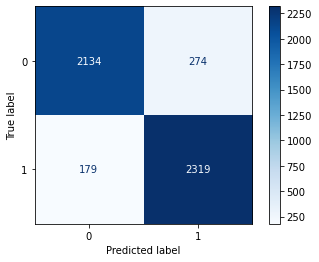

The Accurracy score is 0.9076640847941296
The Sensitivity score is 0.9283426741393115
The Precision score is 0.8943308908600077
____________________
Receiver Operating Characteristic (ROC) curve:


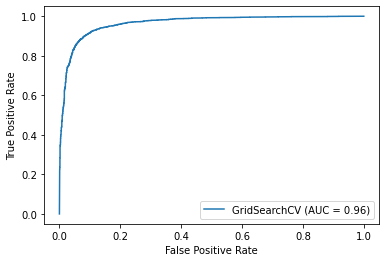

'Model scored!'

In [36]:
maxfeats = [15_000, 20_000, 30_000] #try different volume of features
mindf = [3, 5] #minimum word frequency to be included in the model
maxdf = [.8, .9] #cutoff for words more frequent than percentage (float) threshhold
ngrams = [(1,2), (1,3)] #range of combinations of words to try (minimum, maximum)
swords = [None, stopwords.words('english')] #try None and a standard stop word list
scaler = 'cvec'
classifier = 'nb'

pipe = utils.pipemaker(scaler, classifier)
params = utils.set_params(scaler, maxfeats, mindf, maxdf, swords, ngrams)

gs = GridSearchCV(pipe, params, #load hyperparameters
                  n_jobs=4,        #use 4 cores to process faster
                  cv=5, verbose=1) #using 5 folds and lower verbose to limit messages returned

#gs.fit(X_train, y_train)

#utils.score_model(gs, X_train, y_train, X_test, y_test)

#### score_model() output:

The best parameters are: {'cvec__max_df': 0.8, 'cvec__max_features': 15000, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': {list of stop words}  
The test score is: 0.9076640847941296  
____________________
Confusion Matrix for Test Set: (not shown)

The Accurracy score is 0.9076640847941296  
The Sensitivity score is 0.9283426741393115  
The Precision score is 0.8943308908600077  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown)  

'Model scored!'
​

A few takewaways from model 3; the best parameters still included words under 80% frequencey, even with stop words removed. However, the max features hyperparameter of 15k was preferred to 20k which scored best in the two prior models. Minimum frequency was still best at 5, the ngram range was still (1,2), and as we might expect, using the stop word list was preferred to leaving them out. Notwithstanding all of that, my test accuracy score barely improved (about .001). I'm going to switch into the TF-IDF method and see if that makes a difference.

### Model 4  

This will be my first model using the TF-IDF vectorizer which will score word importance as a ratio. I'll just keep all the other parameters the same for comparison purposes, but I am going to save the stopwords.words('english') list as a variable. I'm also going to up my processing speed by adding a 5th core.

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   24.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:  2.3min finished


The best parameters are: {'tvec__max_df': 0.8, 'tvec__max_features': 15000, 'tvec__min_df': 5, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',

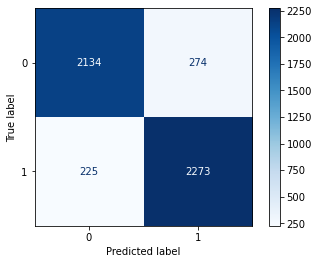

The Accurracy score is 0.8982878108438647
The Sensitivity score is 0.9099279423538831
The Precision score is 0.8924224577934825
____________________
Receiver Operating Characteristic (ROC) curve:


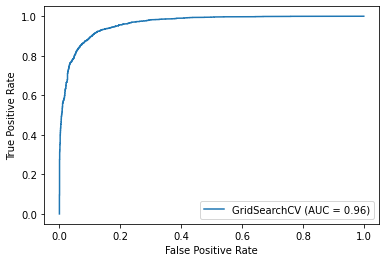

'Model scored!'

In [39]:
nltk_slist = stopwords.words('english')
maxfeats = [15_000, 20_000, 30_000] #try different volume of features
mindf = [3, 5] #minimum word frequency to be included in the model
maxdf = [.8, .9] #cutoff for words more frequent than percentage (float) threshhold
ngrams = [(1,2), (1,3)] #range of combinations of words to try (minimum, maximum)
swords = [None, nltk_slist] #try None and a standard stop word list
scaler = 'tvec' #CHANGING SCALER <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
classifier = 'nb'

pipe = utils.pipemaker(scaler, classifier)
params = utils.set_params(scaler, maxfeats, mindf, maxdf, swords, ngrams)

gs = GridSearchCV(pipe, params, #load hyperparameters
                  n_jobs=5,        #UPPING TO 5 CORES <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
                  cv=5, verbose=1) #using 5 folds and lower verbose to limit messages returned

#gs.fit(X_train, y_train)

#utils.score_model(gs, X_train, y_train, X_test, y_test)

#### score_model() output:  

The best parameters are: {'tvec__max_df': 0.8, 'tvec__max_features': 15000, 'tvec__min_df': 5, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': stop word list}  
The best training score was: 0.8999122595621148  
The test score is: 0.8982878108438647  
____________________
Confusion Matrix for Test Set: (not shown)

The Accurracy score is 0.8982878108438647  
The Sensitivity score is 0.9099279423538831  
The Precision score is 0.8924224577934825  
____________________
Receiver Operating Characteristic (ROC) curve: (not shown)  

'Model scored!'

Interesting. It looks like the best tvec model opted for all the same features than my previous cvec model did, but resulted in lower scores across the board.